In [2]:
import scanpy as sc
import urllib.parse

# Load and look at the data

In [3]:
adata = sc.read_h5ad("2_integrate.h5ad")
adata

AnnData object with n_obs × n_vars = 2353 × 29965
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
  

In [4]:
adata.obs["sample_type"].unique()

['rr_depl']
Categories (1, object): ['rr_depl']

In [5]:
# Specify the embedding to be used
embedding = "X_pca_harmony"

In [6]:
adata.obsm

AxisArrays with keys: X_pca, X_pca_harmony, X_umap, X_umap_harmony

/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/fn/l7sbwldd3ll8jjsyrdbqymxr0000gn/T/ipykernel_16830/3425026837.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


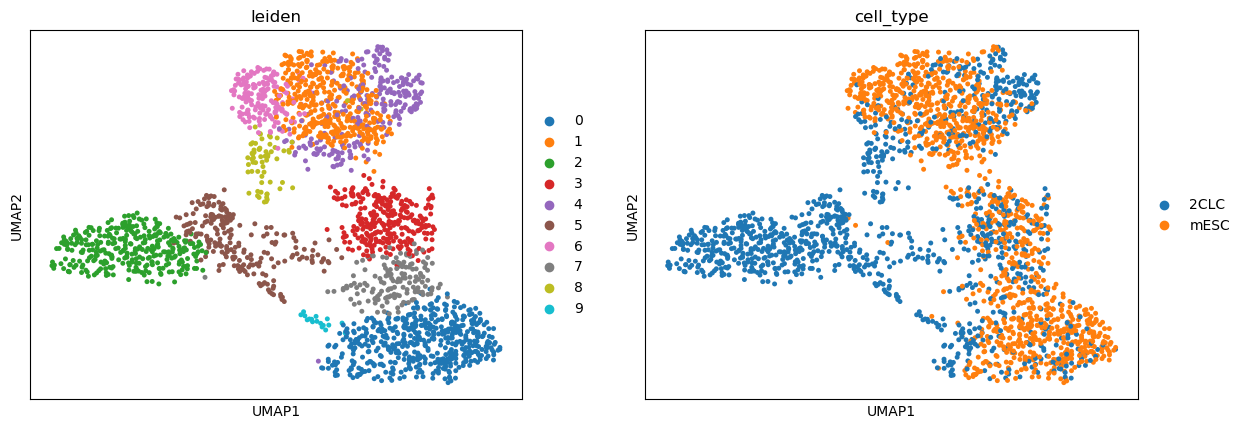

In [7]:
sc.pp.neighbors(adata, use_rep=embedding)
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata)

sc.pl.umap(adata, color=["leiden", "cell_type"])

## Identify clusters that most likely represent 2CLCs

Annotations are often not perfect and it is possible that some cells are mislabeled. Unsupervised clustering finds populations of cells that have similar expression profiles. We assume that the majority of cells in a cluster are correctly labeled. We can use this information to identify clusters that most likely represent 2CLCs.

In [8]:
# For each cluster, find the fraction of 2CLC cells
cluster_2clc = adata.obs.groupby("leiden")["cell_type"].value_counts(normalize=True).unstack().fillna(0)["2CLC"]
adata.uns['2clc_clusters'] = cluster_2clc[cluster_2clc > 0.75].index.to_list()
adata.uns['2clc_clusters']

del cluster_2clc
adata.uns['2clc_clusters']

/var/folders/fn/l7sbwldd3ll8jjsyrdbqymxr0000gn/T/ipykernel_16830/2537633627.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_2clc = adata.obs.groupby("leiden")["cell_type"].value_counts(normalize=True).unstack().fillna(0)["2CLC"]


['2', '5', '8', '9']

# PAGA

PAGA is a method to infer the connectivity of clusters in a dataset.

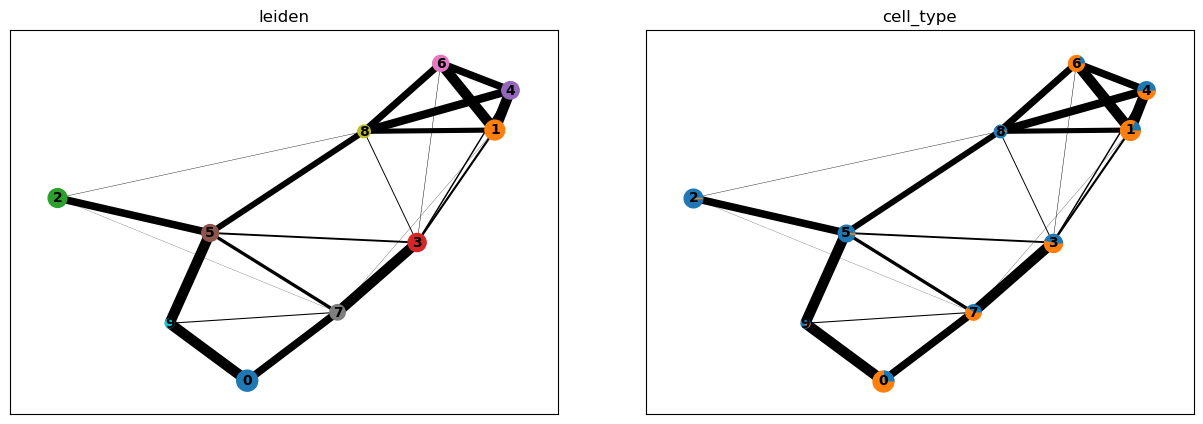

In [9]:
sc.tl.paga(adata, groups="leiden")
sc.pl.paga(adata, color=["leiden", "cell_type"])

# Differential expression analysis

Differential expression analysis can be used to identify genes that are differentially expressed between two groups of cells.
In this case, we can use it to identify genes that are differentially expressed between 2CLCs and mESCs.
It could also be used for identifying differences between specific clusters.

In [10]:
adata.obs["putative_2CLC"] = adata.obs["leiden"].map(lambda x: "2CLC" if x in adata.uns["2clc_clusters"] else "mESC").astype("category")

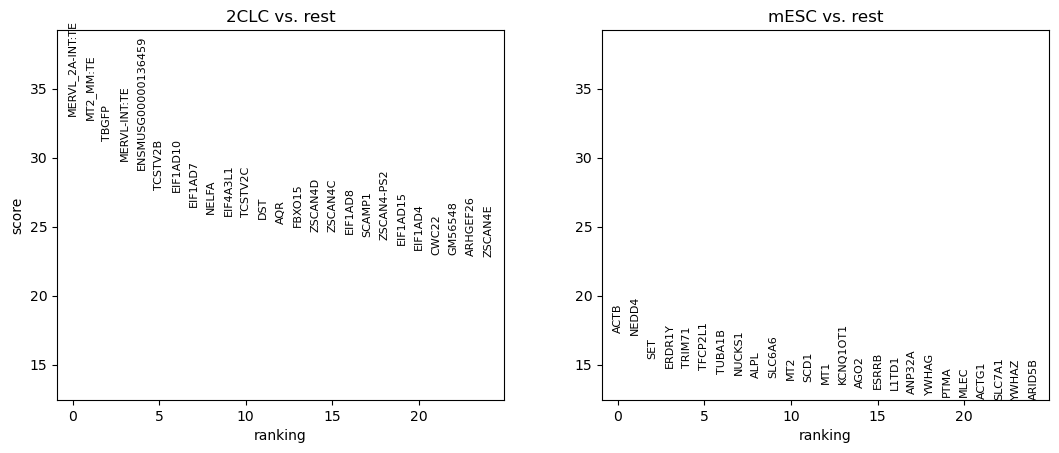

In [11]:
sc.tl.rank_genes_groups(adata, groupby="putative_2CLC", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25)

In [12]:
adata_lnc = adata[:, adata.var["gene_type"] == "lncRNA"].copy()

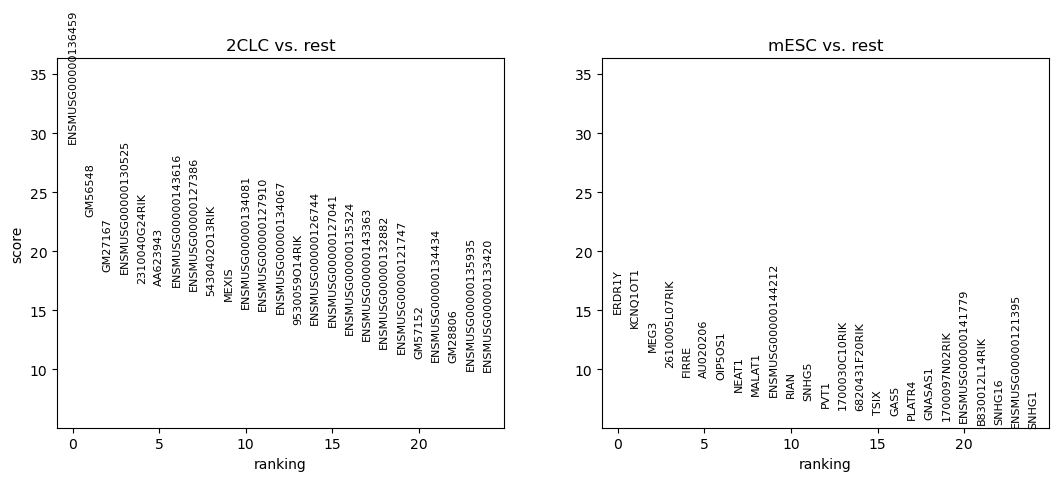

In [13]:
sc.tl.rank_genes_groups(adata_lnc, groupby="putative_2CLC", method="wilcoxon", use_raw = False)
sc.pl.rank_genes_groups(adata_lnc, n_genes=25)

In [14]:
adata_rr = adata[:, adata.var["gene_type"] == "rRNA"].copy()

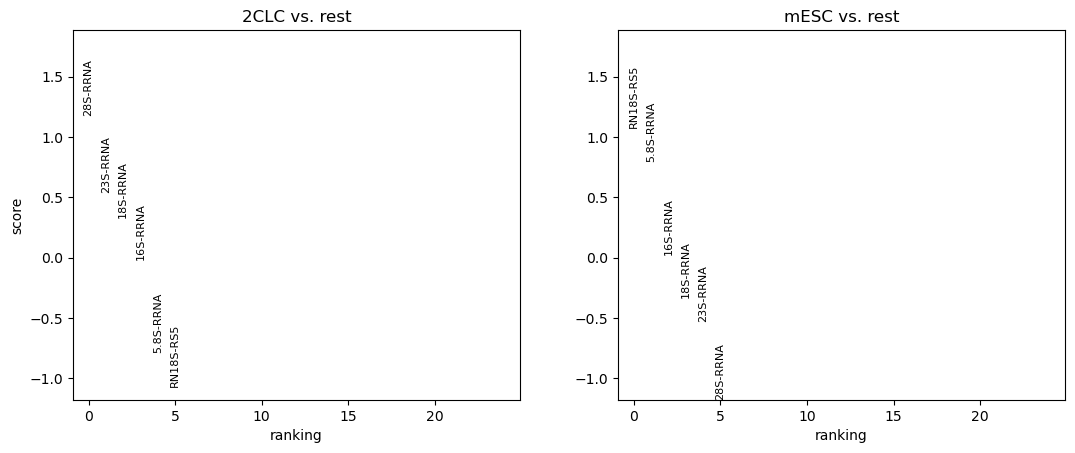

In [15]:
sc.tl.rank_genes_groups(adata_rr, groupby="putative_2CLC", method="wilcoxon", use_raw = False)
sc.pl.rank_genes_groups(adata_rr, n_genes=25)

## Investigating the identified genes

### Gene set enrichment analysis
The following code creates a link to g:Profiler, an online tool for gene set enrichment analysis.

In [16]:
# get top 100 genes for 2CLC
top_genes = adata.uns["rank_genes_groups"]["names"]["2CLC"][:100]
# Create g:profiler link
url = urllib.parse.urlencode({"organism": "mmusculus", "query": " ".join(top_genes)})
print(f"https://biit.cs.ut.ee/gprofiler/gost?{url}")

https://biit.cs.ut.ee/gprofiler/gost?organism=mmusculus&query=MERVL_2A-INT%3ATE+MT2_MM%3ATE+TBGFP+MERVL-INT%3ATE+ENSMUSG00000136459+TCSTV2B+EIF1AD10+EIF1AD7+NELFA+EIF4A3L1+TCSTV2C+DST+AQR+FBXO15+ZSCAN4D+ZSCAN4C+EIF1AD8+SCAMP1+ZSCAN4-PS2+EIF1AD15+EIF1AD4+CWC22+GM56548+ARHGEF26+ZSCAN4E+GLRX2+ALYREFFM10+TCSTV1B+ERCC4+CACNA1S+ROBO1+MTA_MM%3ATE+EIF1AD3+L1MDA_VII%3ATE+ATF2+USP17LC+ORR1A0%3ATE+L1MDF_IV%3ATE+GM12183+ORR1A1%3ATE+GPBP1L1+RBM25+ZSCAN4-PS3+RXRA+ZFP516+EIF1AD6+OS9+P4HA2+USP17LA+GM27167+CAND1+ENSMUSG00000130525+GM6494+L1_MUR2%3ATE+LX3_MUS%3ATE+LX5%3ATE+ORR1A2%3ATE+L1LX_I%3ATE+PREX2+L1LX_IV%3ATE+TSEN2+RLTR6B_MM%3ATE+DDIT4L+2310040G24RIK+L1MDA_III%3ATE+DENND4C+AA623943+GM4971+ENSMUSG00000143616+ZFP560+LX8%3ATE+TMEM92+2810004N23RIK+ENSMUSG00000127386+IAPEZ-INT%3ATE+GSAT_MM%3ATE+L1MDA_VI%3ATE+MMERVK9E_I%3ATE+LX6%3ATE+5430402O13RIK+MMERVK10C-INT%3ATE+L1MDF_III%3ATE+PRPS1+SPESP1+UAP1+L1MDF_I%3ATE+MEXIS+GM1995+L1MDGF_II%3ATE+L1_MUR3%3ATE+USP17LE+USP17LB+EIF4A3L2+PCLO+L1MDA_II%3ATE+LONP2+L1

In [19]:
# get top 50 lnc genes for 2CLC 
top_genes_lnc = adata_lnc.uns["rank_genes_groups"]["names"]["2CLC"][:50]
# Create g:profiler link
url = urllib.parse.urlencode({"organism": "mmusculus", "query": " ".join(top_genes_lnc)})
print(f"https://biit.cs.ut.ee/gprofiler/gost?{url}")

https://biit.cs.ut.ee/gprofiler/gost?organism=mmusculus&query=ENSMUSG00000136459+GM56548+GM27167+ENSMUSG00000130525+2310040G24RIK+AA623943+ENSMUSG00000143616+ENSMUSG00000127386+5430402O13RIK+MEXIS+ENSMUSG00000134081+ENSMUSG00000127910+ENSMUSG00000134067+9530059O14RIK+ENSMUSG00000126744+ENSMUSG00000127041+ENSMUSG00000135324+ENSMUSG00000143363+ENSMUSG00000132882+ENSMUSG00000121747+GM57152+ENSMUSG00000134434+GM28806+ENSMUSG00000135935+ENSMUSG00000133420+ENSMUSG00000134746+ENSMUSG00000122959+ENSMUSG00000142679+GM14742+GM33466+A530040E14RIK+GM38642-1+ENSMUSG00000125890+GM28940+GM41409+AU019990+6530403H02RIK+GM13964+ENSMUSG00000137301+ENSMUSG00000134787+GM38353+GM8016+ENSMUSG00000140514+0610005C13RIK+ENSMUSG00000123477+ENSMUSG00000132977+ENSMUSG00000121444+GM44736+GM53567+ENSMUSG00000132422


In [20]:
# get top 50 lnc genes for 2CLC 
top_genes = adata_rr.uns["rank_genes_groups"]["names"]["2CLC"][:50]
# Create g:profiler link
url = urllib.parse.urlencode({"organism": "mmusculus", "query": " ".join(top_genes)})
print(f"https://biit.cs.ut.ee/gprofiler/gost?{url}")

https://biit.cs.ut.ee/gprofiler/gost?organism=mmusculus&query=28S-RRNA+23S-RRNA+18S-RRNA+16S-RRNA+5.8S-RRNA+RN18S-RS5


# Save

In [62]:
adata.write_h5ad("3_cluster.h5ad")